<a href="https://colab.research.google.com/github/MiniRedTrout/Cauchy-problem-/blob/main/Num_m8lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [345]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Часть №1. Расчетные схемы метода Рунге-Кутты с постоянным шагом**

1.1. Используя условия порядка для 2-х-этапного ЯМРК 2-го порядка постройте расчетную
схему второго порядка при значении параметра 𝑐2 = 𝜉 (параметр 𝜉 указан в Вашем варианте
задания).

Мой вариант - a) e = 1/8 b) A = 1/15, B = 1/20

In [346]:
A = 1/15
B = 1/20
x0 = 0
y0 = np.array([B * np.pi, A * np.pi])
x_target = np.pi

In [347]:
def f(x, y):
    y1, y2 = y
    return np.array([A * y2, -B * y1])

def solution(x):
    omega = np.sqrt(A * B)
    y1 = B * np.pi * np.cos(omega * x) + (A**2 * np.pi / omega) * np.sin(omega * x)
    y2 = A * np.pi * np.cos(omega * x) - (B**2 * np.pi / omega) * np.sin(omega * x)

    return np.array([y1,y2])

In [348]:
def graf(x_values, y_values):
    fig, axes = plt.subplots(1, 1, figsize=(22, 6))

    axes.plot(x_values, y_values[:, 0], 'b-', linewidth=2, label='y1(x) - числ.')
    axes.plot(x_values, y_values[:, 1], 'r-', linewidth=2, label='y2(x) - числ.')

    x_dense = np.linspace(x_values[0], x_values[-1], 1000)
    y_exact_dense = np.array([solution(x) for x in x_dense])
    axes.plot(x_dense, y_exact_dense[:, 0], 'b--', alpha=0.7, label='y1(x) - точн.')
    axes.plot(x_dense, y_exact_dense[:, 1], 'r--', alpha=0.7, label='y2(x) - точн.')

    axes.set_xlabel('x')
    axes.set_ylabel('y(x)')
    axes.set_title('Решения системы ОДУ')
    axes.legend()
    axes.grid(True, alpha=0.3)

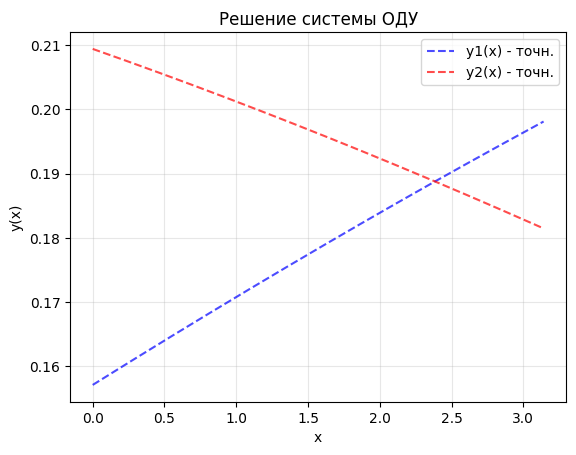

In [349]:
x_dense = np.linspace(x0, x_target, 1000)
y_exact = solution(x_dense)
plt.plot(x_dense, y_exact[0], 'b--', alpha=0.7, label='y1(x) - точн.')
plt.plot(x_dense, y_exact[1], 'r--', alpha=0.7, label='y2(x) - точн.')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Решение системы ОДУ')
plt.grid(True, alpha=0.3)
plt.legend()

In [350]:
def runge_kutta_2m(f, x, y, h, n_steps):
    """
    b1 = -3, b2 = 4, c2 = 1/8, a21 = 1/8
    """
    y_current = y.copy()
    x_current = x

    for _ in range(n_steps):
        k1 = h * f(x_current, y_current)
        k2 = h * f(x_current + (1/8)*h, y_current + (1/8)*k1)

        y_current = y_current + (-3)*k1 + 4*k2
        x_current += h
    return y_current

In [390]:
y_num = runge_kutta_2m(f, x0, y0, int(np.ceil(x_target - x0) / 2),2)

In [391]:
y_exact = solution(x_target)

In [392]:
print(f'abs err y1: {abs(y_exact[0] - y_num[0])}')
print(f'abs err y2: {abs(y_exact[1] - y_num[1])}')

abs err y1: 0.010248383134873085
abs err y2: 0.008807582088355276


1.2. Постройте и программно реализуйте алгоритм решения задачи Коши (1) с заданной
точностью (𝜀 = 10−4) с постоянным шагом интегрирования и оценкой полной погрешности
по методу Рунге. Параметры A, В указаны в Вашем варианте. Начальный шаг выбирать
согласно алгоритму выбора начального шага (стр. 15 методического пособия).

Глобальная погрешность =
  + Накопленные локальные погрешности (метод Рунге оценивает только эту часть)
  + Методическая погрешность (погрешность метода)
  + Вычислительная погрешность (округления)
  + Погрешность начальных данных
  + Погрешность модели

Ri = y(xi) − y˜i ≈(˜yi − ¯yi)/(2^s − 1)

In [389]:
def select_initial_step(system_equations, x0, y0, x_end, epsilon=1e-4, s=2):
    def calculate_step(x, y):
        f0 = system_equations(x, y)
        x_norm = 1/(max(abs(x0), abs(x_end)))
        f_norm = np.linalg.norm(f0)
        delta = x_norm**(s+1) + f_norm**(s+1)
        h = (epsilon/delta)**(1/(s+1))
        return h, f0

    h1, f0_initial = calculate_step(x0, y0)
    is_special_case = np.allclose(f0_initial, 0, atol=1e-10)
    if is_special_case:
        y2 = y0 + h1 * f0_initial
        h2, f0_new = calculate_step(x0 + h1, y2)
        h_constant = min(h1, h2)
    else:
        h_constant = h1
    print(f"Выбран постоянный шаг: h = {h_constant:.6f}")
    return h_constant

def solve_with_fixed_step(system_equations, runge_kutta_method, x0, y0, h, n_steps):
    x_values = np.zeros(n_steps + 1)
    y_values = np.zeros((n_steps + 1, len(y0)))
    x_values[0] = x0
    y_values[0] = y0

    for i in range(n_steps):
        x = x_values[i]
        y = y_values[i]
        y_values[i + 1] = runge_kutta_method(system_equations, x, y, h,n_steps=1)
        x_values[i + 1] = x + h
    return x_values, y_values
def solve_with_constant_step(system_equations, exact_solution, runge_kutta,x0, y0, x_end, s=2,epsilon=1e-4, max_iter=10):
    global_errors = []
    h_current = select_initial_step(system_equations, x0, y0, x_end, epsilon, s=2)
    n_steps = int(np.ceil((x_end - x0) / h_current))
    h_adjusted = (x_end - x0) / n_steps
    print(f"Количество шагов: {n_steps}")
    x_h, y_h = solve_with_fixed_step(system_equations, runge_kutta, x0, y0, h_adjusted, n_steps)
    n_steps_h2 = n_steps * 2
    h_half = h_adjusted / 2
    x_h2, y_h2 = solve_with_fixed_step(system_equations, runge_kutta, x0, y0, h_half, n_steps_h2)
    global_error_estimate = np.linalg.norm(y_h2[-1] - y_h[-1]) / (2**2 - 1)
    global_errors.append(global_error_estimate)
    print(f"оценка погрешности: {global_error_estimate:.2e}")
    return x_h, y_h, global_error_estimate, h_adjusted, max_iter

In [393]:
x_values2, y_values2, global_errors2, h_adjusted2,iter = solve_with_constant_step(f, solution, runge_kutta_2m,
                           x0, y0, x_target, epsilon=1e-4)

Выбран постоянный шаг: h = 0.145814
Количество шагов: 22
оценка погрешности: 1.39e-07


In [394]:
diff1 = np.linalg.norm(y_exact - y_values2[-1])

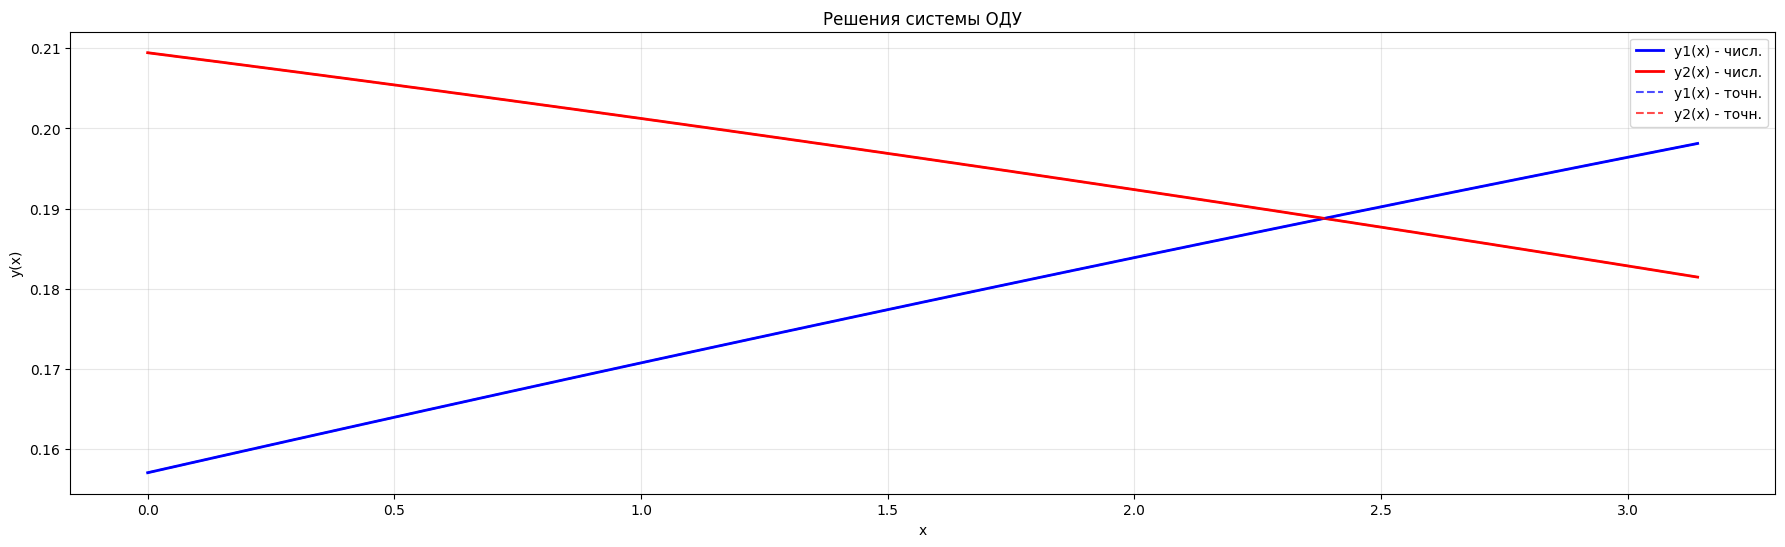

In [395]:
graf(x_values2, y_values2)

**Часть №2. Расчетные схемы метода Рунге-Кутты с автоматическим выбором шага**

2.1. Реализуйте алгоритм решения задачи Коши (1) на базе построенной Вами (см. п. 1.1.)
схемы 2-х-этапного ЯМРК 2-го порядка с автоматическим выбором шага с заданной
максимально допустимой локальной погрешностью (𝜌 = 10−5) и оценкой локальной
погрешности по методу Рунге. Начальный шаг выбирать так же, как и в п. 1.2.

In [358]:
def estimate_local_error(f, method, x, y, h, p=2):
    y_h = method(f, x, y, h,n_steps=1)
    y_half1 = method(f, x, y, h/2,n_steps=1)
    y_half2 = method(f, x + h/2, y_half1, h/2,n_steps=1)
    local_error = np.linalg.norm(y_half2 - y_h) / (2**p - 1)

    return local_error, y_half2
def solve_adaptive_runge_kutta(system_equations, runge_kutta,x0, y0, x_end, e=1e-5, s=2):
    x_values = [x0]
    y_values = [y0.copy()]
    h_values = [0.0]
    error_estimates = [0.0]

    h_current = select_initial_step(system_equations, x0, y0, x_end, e, s)

    x_current = x0
    y_current = y0.copy()
    y_next = 0
    max_steps = 10000
    step_count = 0
    count = 0

    while x_current < x_end and step_count < max_steps:
        h = min(h_current, x_end - x_current)
        local_error, y_next = estimate_local_error(
            system_equations, runge_kutta, x_current, y_current, h, s)
        if s == 2:
            count += 6
        else:
            count += 9
        if local_error > e * (2 ** s):
            h_current = h / 2
            continue

        elif local_error > e:
            x_next = x_current + h
            h_current = h / 2

        elif local_error >= e / (2 ** (s + 1)):
            x_next = x_current + h
            h_current = h

        else:
            x_next = x_current + h
            h_current = min(2 * h,(x_target - x0))
        x_values.append(x_next)
        y_values.append(y_next.copy())
        h_values.append(h)
        error_estimates.append(local_error)
        x_current = x_next
        y_current = y_next
        step_count += 1

    print(f"Всего шагов: {step_count}")
    print(f"Финальный шаг: h = {h_current:.6f}")
    print(f"Всего вычислений правых частей: {count}")

    return np.array(x_values), np.array(y_values), np.array(h_values), np.array(error_estimates), count

In [359]:
x_values_a1,y_values_a1,h_adjusted_a1,local_errors_a1,count_a1 = solve_adaptive_runge_kutta(f, runge_kutta_2m, x0, y0, x_target, e=1e-5, s=2)

Выбран постоянный шаг: h = 0.067681
Всего шагов: 6
Финальный шаг: h = 1.043491
Всего вычислений правых частей: 36


In [360]:
diff2 = np.linalg.norm(y_exact - y_values_a1[-1])

In [361]:
diff1 - diff2

np.float64(-5.079620569000622e-06)

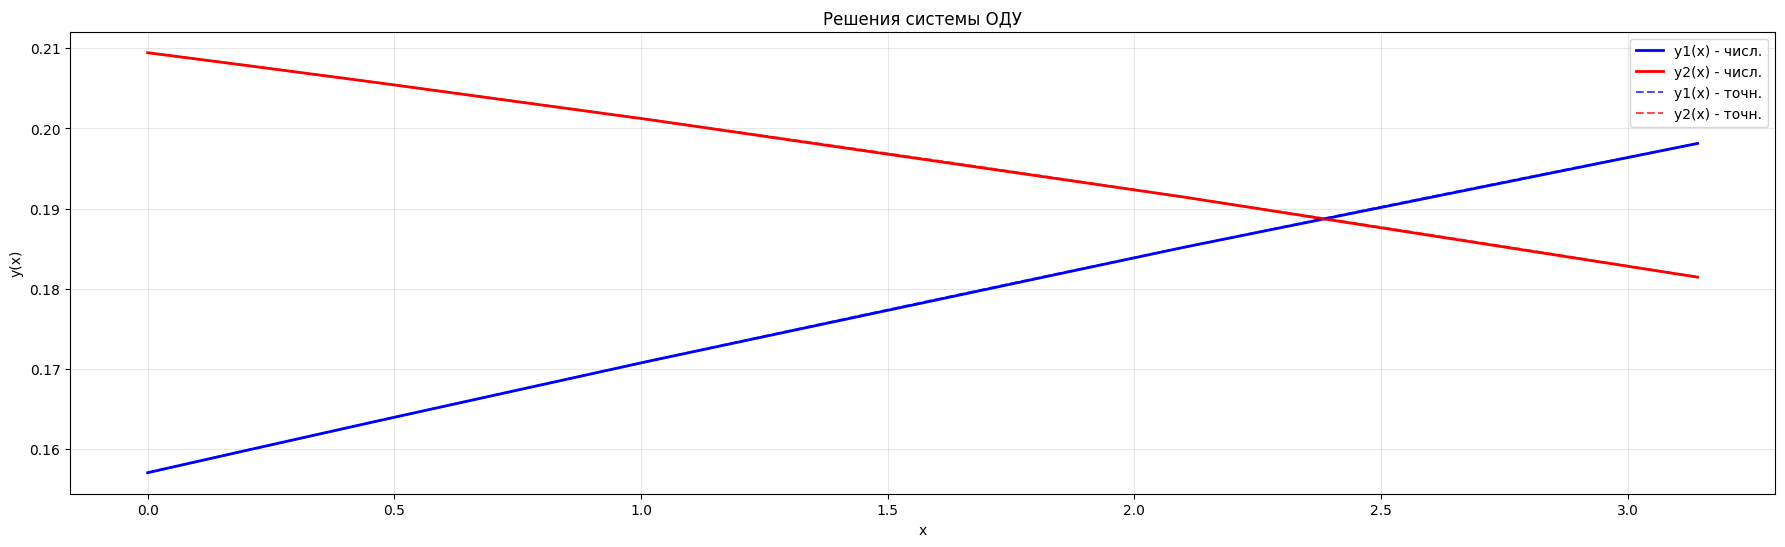

In [362]:
graf(x_values_a1,y_values_a1)

Реализуйте алгоритмы решения задачи Коши с постоянным и автоматическим
выбором шага на базе одной из классических расчетных схем интегрирования 3 или 4
порядка точности

3 порядок

In [363]:
def runge_kutta_3m(f, x, y, h,n_steps):
    k1 = h * f(x, y)
    k2 = h * f(x + h/3, y + k1/3)
    k3 = h * f(x + 2*h/3, y + 2*k2/3)

    y_next = y + (k1 + 3*k3) / 4
    return y_next

Постоянный шаг

x_values, y_values, global_errors, h_adjusted,iter = solve_with_constant_step(f, solution,
                           x0, y0, x_target, s=3,epsilon=1e-4)

In [364]:
x_values3, y_values3, global_errors3, h_adjusted3,iter = solve_with_constant_step(f, solution, runge_kutta_3m,
                           x0, y0, x_target,s=3, epsilon=1e-4)

Выбран постоянный шаг: h = 0.145814
Количество шагов: 22
оценка погрешности: 3.32e-10


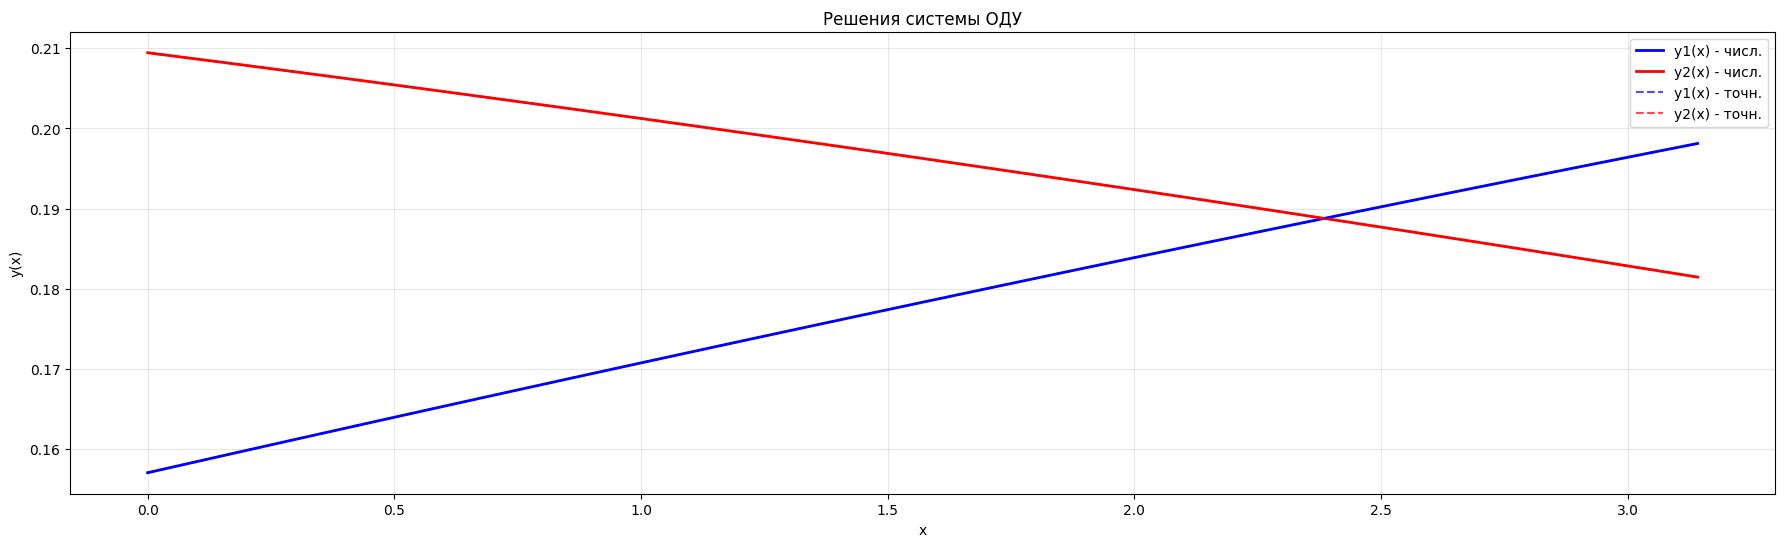

In [365]:
graf(x_values3, y_values3)

In [366]:

x_values_a2,y_values_a2,h_adjusted_a2,local_errors_a2, count_a2 = solve_adaptive_runge_kutta(f, runge_kutta_3m, x0, y0, x_target, e=1e-5, s=3)

Выбран постоянный шаг: h = 0.176664
Всего шагов: 5
Финальный шаг: h = 0.983252
Всего вычислений правых частей: 45


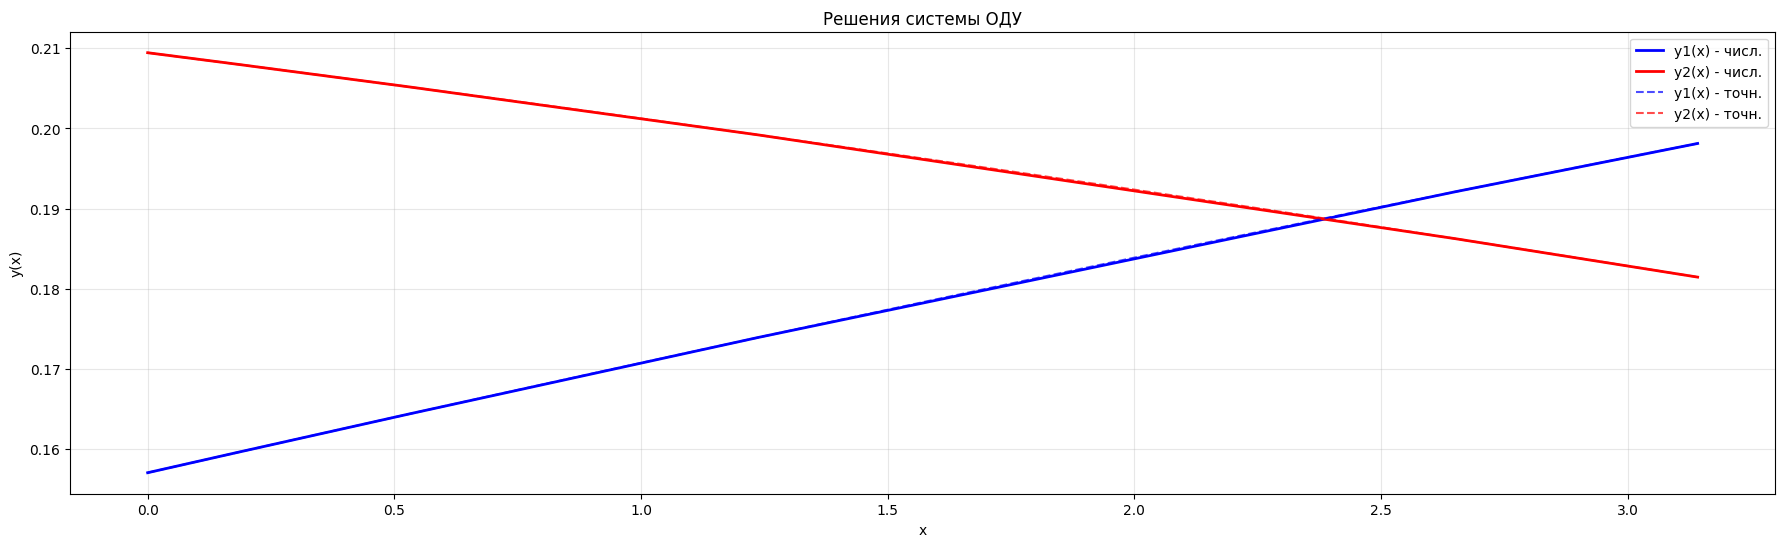

In [367]:
graf(x_values_a2,y_values_a2)

3.2. Для выбранного метода (схемы оппонента) из п. 3.1 и реализованного Вами в п.1.2 2-
х этапного ЯМРК 2-го порядка для решения задачи Коши (1) с постоянным шагом
определите величину шага интегрирования ℎ, обеспечивающего вычисление
приближенного решения с заданной точностью (𝜀 = 10−4). Постройте графики
зависимости истинной полной погрешности от значения независимой переменной 𝑥 при
интегрировании с полученным шагом ℎ.

In [368]:
def plot_single_error_graph_simple(x_values, y_values, exact_solution):
    y_exact = exact_solution(x_values)
    total_errors = np.linalg.norm(y_values - y_exact.T, axis=1)

    plt.figure(figsize=(10, 6))
    plt.semilogy(x_values, total_errors, 'g-', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('Общая погрешность')
    plt.grid(True)
    plt.show()

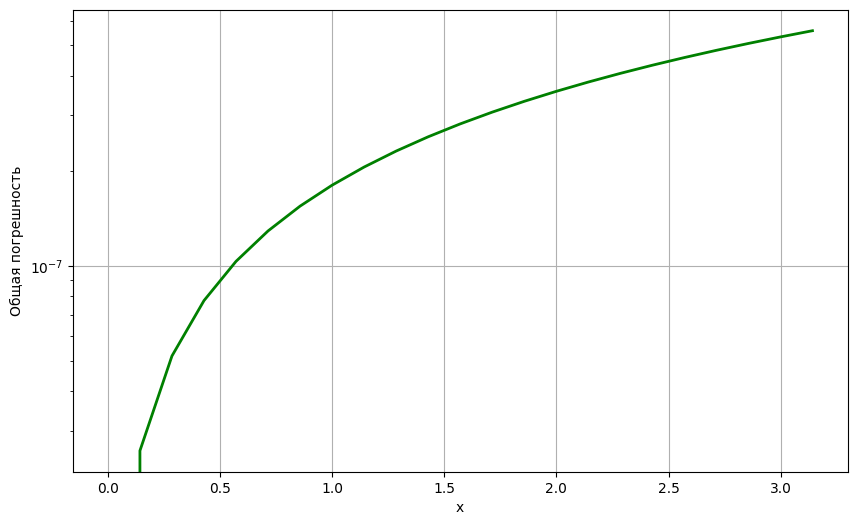

In [369]:
plot_single_error_graph_simple(x_values2,y_values2,solution)

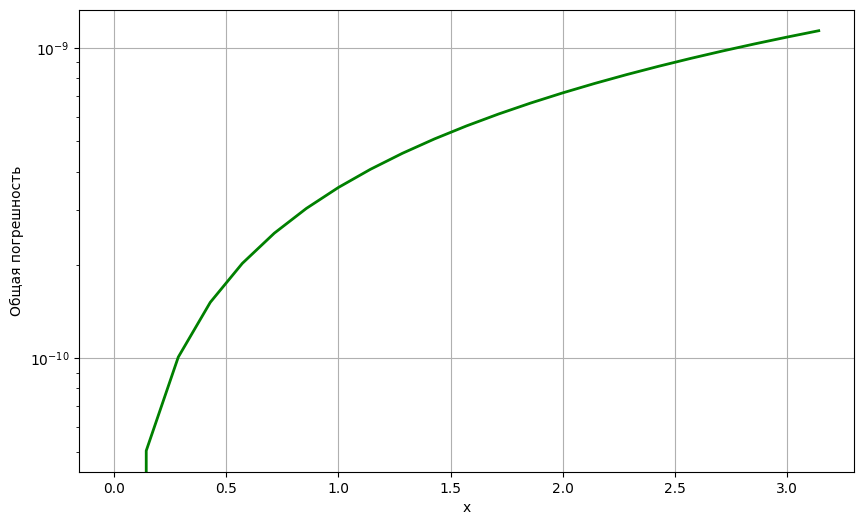

In [370]:
plot_single_error_graph_simple(x_values3,y_values3,solution)

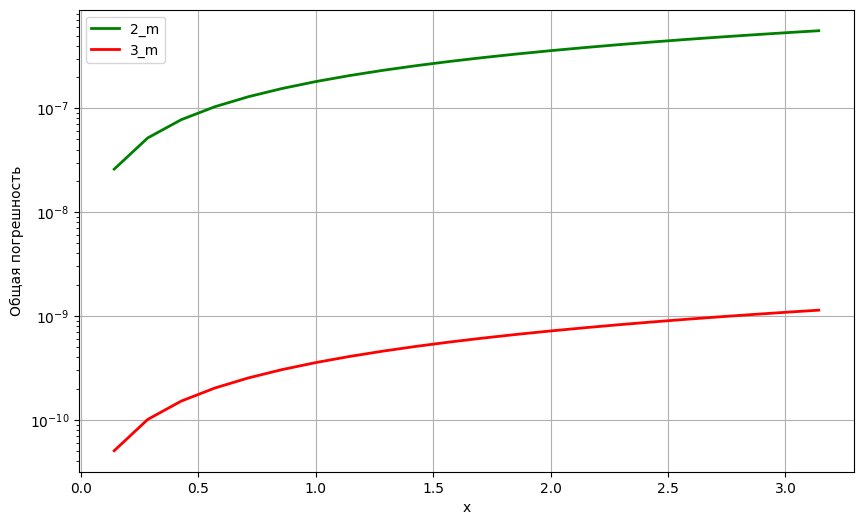

In [371]:
y_exact2 = solution(x_values2[1:])
total_errors2 = np.linalg.norm(y_values2[1:] - y_exact2.T, axis=1)

y_exact3 = solution(x_values3[1:])
total_errors3 = np.linalg.norm(y_values3[1:] - y_exact3.T, axis=1)

plt.figure(figsize=(10, 6))
plt.semilogy(x_values2[1:], total_errors2, 'g-', label='2_m', linewidth=2)
plt.semilogy(x_values3[1:], total_errors3, 'r-', label='3_m', linewidth=2)
plt.xlabel('x')
plt.ylabel('Общая погрешность')
plt.grid(True)
plt.legend()
plt.show()


3.3. Для схемы оппонента из п. 3.1 и реализованного Вами в п.2.1 2-х этапного ЯМРК 2-
го порядка для решения задачи Коши (1) с автоматическим выбором шага интегрирования
постройте:

3.3.1 графики зависимости величины шага интегрирования от значения независимой
переменной 𝑥;

In [343]:
def plot_comparison_step_sizes(x_values_method1, h_values_method1,
                              x_values_method2, h_values_method2,
                              method1_name="Метод 1", method2_name="Метод 2"):

    plt.semilogy(x_values_method1, h_values_method1, 'b-',
                 linewidth=2, label=method1_name, alpha=0.7)
    plt.semilogy(x_values_method2, h_values_method2, 'r--',
                 linewidth=2, label=method2_name, alpha=0.7)
    plt.xlabel('x')
    plt.ylabel('log(h)')
    plt.legend()

    plt.tight_layout()
    plt.show()

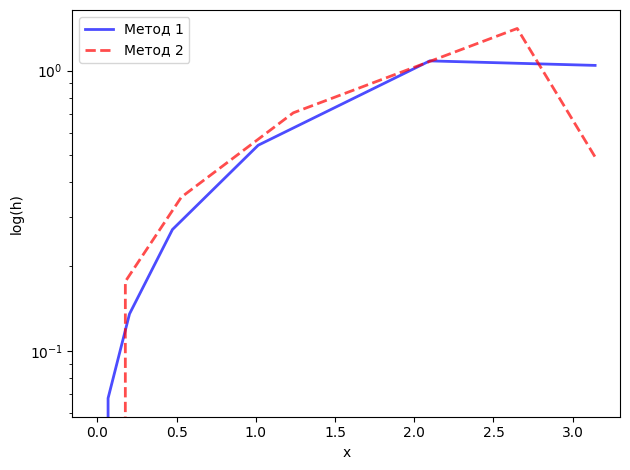

In [344]:
plot_comparison_step_sizes(x_values_a1,h_adjusted_a1,x_values_a2,h_adjusted_a2)

3.3.2 графики зависимости отношения истинной локальной погрешности к полученной
оценке локальной погрешности от значения независимой переменной

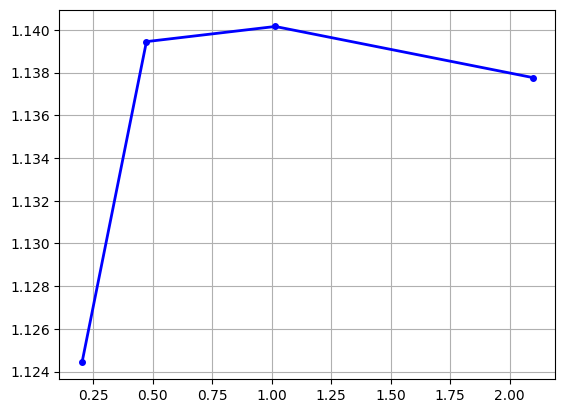

In [380]:
def compute_true_local_errors(system_equations, exact_solution, x_values, y_values):
    true_local_errors = []
    for i in range(len(x_values)):
        true_local_errors.append(np.linalg.norm(exact_solution(x_values[i]).T - (y_values)[i]))
    return np.array(true_local_errors)

def compute_local_error_ratios(system_equations, exact_solution, x_values, y_values, p=2):
    true_local_errors = compute_true_local_errors(system_equations, exact_solution, x_values, y_values)
    if p == 2:
        estimated_local_errors = local_errors_a1
        err = np.abs(true_local_errors[1:])/np.abs(h_adjusted_a1[1:]*1e-5)
    else:
        estimated_local_errors = local_errors_a2
        err = np.abs(true_local_errors[1:])/np.abs(h_adjusted_a2[1:]*1e-5)
    error_ratios = np.abs(true_local_errors[1:]) / np.abs(estimated_local_errors[1:])

    return x_values, true_local_errors, estimated_local_errors, error_ratios,err

def plot_local_error_ratios(x_midpoints, error_ratios,err):
    plt.plot(x_midpoints[2:-1], error_ratios[1:], 'b-', linewidth=2, marker='o', markersize=4)
    #plt.semilogy(x_midpoints[1:],err)
    plt.grid()
    plt.show()
def complete_task_3_3_2(system_equations, exact_solution, x0, y0, p=2):
    if p == 2:
        x_midpoints, true_local_errors, estimated_local_errors, error_ratios,err = \
        compute_local_error_ratios(system_equations, exact_solution, x_values_a1, y_values_a1, p=2)
    else:
        x_midpoints, true_local_errors, estimated_local_errors, error_ratios,err = \
        compute_local_error_ratios(system_equations, exact_solution, x_values_a2, y_values_a2, p=3)
    plot_local_error_ratios(x_midpoints, error_ratios[:-1],err)
    return x_midpoints, true_local_errors, estimated_local_errors, error_ratios

x_midpoints, true_errors, estimated_errors, ratios = \
        complete_task_3_3_2(f, solution, x_values_a1, y_values_a1,p=2)

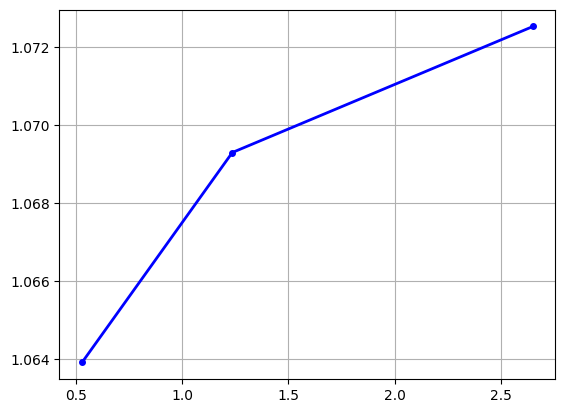

In [381]:

x_midpoints, true_errors, estimated_errors, ratios = \
        complete_task_3_3_2(f, solution, x_values_a2, y_values_a2, p=3)

3.3.3 графики зависимости количества вычислений правой части системы от заданной
точности 𝜀𝜀 (например, 𝜀𝜀 = 10−1, 10−2, 10−3, 10−4, 10−5 ).

Выбран постоянный шаг: h = 1.458136
Всего шагов: 2
Финальный шаг: h = 3.141593
Всего вычислений правых частей: 12
Выбран постоянный шаг: h = 0.676807
Всего шагов: 3
Финальный шаг: h = 2.222344
Всего вычислений правых частей: 18
Выбран постоянный шаг: h = 0.314146
Всего шагов: 4
Финальный шаг: h = 1.885142
Всего вычислений правых частей: 24
Выбран постоянный шаг: h = 0.145814
Всего шагов: 5
Финальный шаг: h = 1.908777
Всего вычислений правых частей: 30
Выбран постоянный шаг: h = 0.067681
Всего шагов: 6
Финальный шаг: h = 1.043491
Всего вычислений правых частей: 36


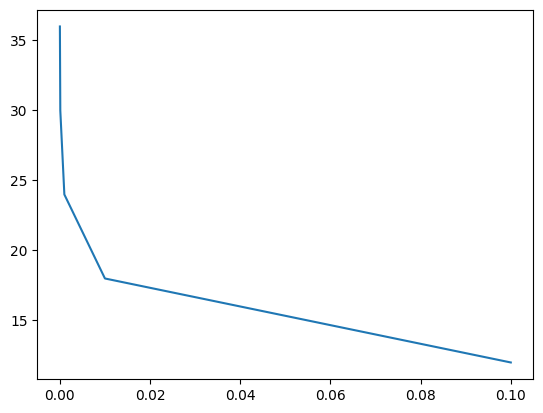

In [385]:
c_1 = []
err =  [1e-1,1e-2,1e-3,1e-4, 1e-5]
for i in err:
  x1,y1,h1,l1,c1 = solve_adaptive_runge_kutta(f,runge_kutta_2m,x0,y0,x_target,i,s=2)
  c_1.append(c1)
plt.plot(err, c_1)

Выбран постоянный шаг: h = 1.766645
Всего шагов: 2
Финальный шаг: h = 2.749896
Всего вычислений правых частей: 18
Выбран постоянный шаг: h = 0.993457
Всего шагов: 3
Финальный шаг: h = 0.322442
Всего вычислений правых частей: 27
Выбран постоянный шаг: h = 0.558662
Всего шагов: 3
Финальный шаг: h = 2.931213
Всего вычислений правых частей: 27
Выбран постоянный шаг: h = 0.314159
Всего шагов: 4
Финальный шаг: h = 1.884963
Всего вычислений правых частей: 36
Выбран постоянный шаг: h = 0.176664
Всего шагов: 5
Финальный шаг: h = 0.983252
Всего вычислений правых частей: 45


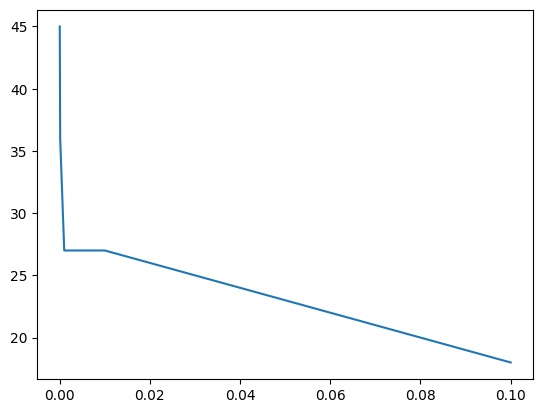

In [384]:
c_2 = []
err =  [1e-1,1e-2,1e-3,1e-4, 1e-5]
for i in err:
  x2,y2,h2,l2,c2 = solve_adaptive_runge_kutta(f,runge_kutta_3m,x0,y0,x_target,i,s=3)
  c_2.append(c2)
plt.plot(err, c_2)

In [375]:
w